In [1]:
%matplotlib inline
import torch
import torch.nn.functional as F
import torchvision
import time
from matplotlib import pyplot as plt

In [2]:
input_transform = torchvision.transforms.Compose(
    [torchvision.transforms.ToTensor(),
     torchvision.transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

train_ds = torchvision.datasets.CIFAR10(root="./tmp_data/", train=True, transform=input_transform, target_transform=None, download=True)
test_ds = torchvision.datasets.CIFAR10(root="./tmp_data/", train=False, transform=input_transform, target_transform=None, download=True)

classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

def plot_batches(batch):
    if not torch.is_tensor(batch):
        batch = iter(batch).next()[0]
    plt.imshow(torchvision.utils.make_grid(batch).transpose(0,2).transpose(0,1)/2.0+.5)



Files already downloaded and verified
Files already downloaded and verified


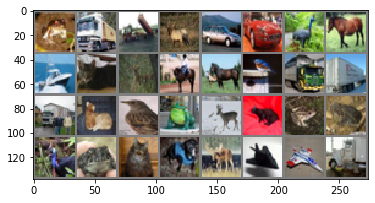

In [3]:
train_dl = torch.utils.data.DataLoader(train_ds, batch_size=32, shuffle=False)
test_dl = torch.utils.data.DataLoader(test_ds, batch_size=10, shuffle=False)
plot_batches(train_dl)

In [4]:
class SimpleNet(torch.nn.Module):
    def __init__(self):
        super(SimpleNet, self).__init__()
        self.conv1 = torch.nn.Conv2d(3, 6, 5)
        self.pool = torch.nn.MaxPool2d(2, 2)
        self.conv2 = torch.nn.Conv2d(6, 16, 5)
        self.fc1 = torch.nn.Linear(16 * 5 * 5, 120)
        self.fc2 = torch.nn.Linear(120, 84)
        self.fc3 = torch.nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [5]:
def validate(model, validation_dataloader):
    with torch.no_grad():
        model.train(False)
        device = list(model.parameters())[0].device
        correct=0
        total=0
        for inputs, targets in validation_dataloader:
            inputs=inputs.to(device)
            targets=targets.to(device)
            outputs = model(inputs)
            predictions=outputs.max(dim=1)[1]
            total += inputs.size(0)
            correct += (targets==predictions).sum().item()
        error = 1 - (correct/total)
        return error
        
def train(model, train_dl, epochs=1, validate_dl=None, criterion=None, optimizer=None):
    device = list(model.parameters())[0].device
    if criterion is None:
        criterion = torch.nn.CrossEntropyLoss()
    if optimizer is None:
        optimizer = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
    time_stamp = time.time()
    for epoch in range(epochs):
        model.train(True)
        correct=0
        total=0
        for inputs, targets in train_dl:
            inputs=inputs.to(device)
            targets=targets.to(device)
            optimizer.zero_grad() # step 1
            outputs = model(inputs)
            predictions=outputs.max(dim=1)[1]
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()
            total += inputs.size(0)
            correct += (targets==predictions).sum().item()
            train_error = 1 - (correct/total)
        if validate_dl is not None:
            validate_error = validate(model,validate_dl)
        else:
            validate_error = "N/A"
        duration_sec = int(time.time() - time_stamp)
        print(f"Epoch {1+epoch}, {duration_sec} sec., Train error: {train_error}")
    return train_error, validate_error, duration_sec
    
def show_inference(model, batch, class_names):
    batch = batch.transpose(0,2).contiguous().view()
    images = (batch).transpose(0,2).transpose(0,1)/2.0+.5
    

In [6]:
#model = model.to("cuda")
#train(model, train_dl, epochs=60)
#torch.save(model.state_dict(), "./pretrained/cifar10_60_epochs.pt")

In [7]:
model = SimpleNet()
model.load_state_dict(torch.load("./pretrained/cifar10_60_epochs.pt"))

<All keys matched successfully>

In [8]:
 # TODO: Write a CIFAR 10 wrpper

In [9]:
class MyChangedCifar():
    def __init__(self, dataset, label_mapping):
        pass
    
    def __getitem__(self, n):
        raise NotImplemented()
        
    def __len__(self, n):
        raise NotImplemented()

In [10]:
# ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')
label_mapping = {0:0, 1:0, 2:1, 3:1, 4:1, 5:1, 6:1, 7:1, 8:0, 9:0}
new_train_ds = MyChangedCifar(train_ds, label_mapping)
new_test_ds = MyChangedCifar(train_ds, label_mapping)
new_train_dl = torch.utils.data.DataLoader(new_train_ds, batch_size=32, shuffle=False)
new_test_dl = torch.utils.data.DataLoader(new_test_ds, batch_size=10, shuffle=False)
train(model, train_dl, epochs=60)

Other References:

* Face Landmark tutorial (https://pytorch.org/tutorials/beginner/data_loading_tutorial.html)
* Classification tutorial (https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html)